<a id="top"></a>
# Land Change

<hr>

# Notebook Summary

This notebook uses changes in NDVI, EVI or Fractional Cover to identify land change. 
The algorithm identifies a "baseline" and "analysis" time period and then compares 
the spectral parameters in each of those time periods. Significant reductions in 
vegetation are coincident with land change. In some cases these changes could be 
deforestation. Users of this algorithm should not accept the accuracy of the results 
but should conduct ground validation testing to assess accuracy. In most cases, these 
algorithms can be used to identify clusters of pixels that have experienced change and 
allow targeted investigation of those areas by local or regional governments.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Define Analysis Parameters](#define_analysis_params)
* [Load and Clean Data from the Data Cube](#load_data)
* [Calculate Spectral Indices and Fractional Cover](#calculate)
* [Show Threshold Image](#threshold)
* [Show Anomalies](#anomalies)
    * Show Spectral Anomaly Product
    * Show Threshold Spectral Anomaly Product
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Enable importing of utilities.
import sys
sys.path.append('..')

# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [2]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

product = "ls7_usgs_sr_scene"
platform = "LANDSAT_7"

# product = "ls8_usgs_sr_scene"
# platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [3]:
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-12.57305555565614, 18.32305555570214)
Longitude Extents: (-25.66583333353866, 44.05861111146359)
Time Extents: ['1999-07-08', '2020-01-10']


**Visualize the available area**

In [4]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [5]:
# Select an analysis region 

# Mau Forest - Western Kenya
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Nairobi, Kenya
latitude = (-1.4347, -1.151) 
longitude = (36.6985, 36.9978) 

# Dar es Salaam, Tanzania
# latitude = (-7.0, -6.7)
# longitude = (39.1, 39.4)

# Phu Thuy, Vietnam
# latitude = (10.8945, 10.9679)
# longitude = (108.0616, 108.1460)

**Visualize the selected area**

In [6]:
display_map(latitude = latitude, longitude = longitude)

## <span id="define_analysis_params">Define Analysis Parameters [&#9652;](#top)</span>  

<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

# Select the baseline time period (start and end)
baseline_time_period = ("2002-01-01", "2002-12-31")

# Select the analysis time period (start and end)
analysis_time_period = ("2015-01-01", "2015-12-31")

# Select the cloud-free mosaic type
# Options are: max_ndvi, min_ndvi, median, most_recent_pixel, geomedian
# If a geomedian is selected, it will take much longer to process
# It is most common to use the max_ndvi or median for these land change analyses
# HINT: Consider max_ndvi mosaics for NDVI analyses and median mosaics for EVI analyses 

baseline_mosaic_function = "median" 
analysis_mosaic_function = "median" 

## <span id="load_data">Load, Clean, and Mosaic Data from the Data Cube [&#9652;](#top)</span>

>#### Load Data (Baseline, Analysis) 

In [8]:
import datacube
name = "land change"
version = 1
dc = datacube.Datacube(app = f"{name}_v{version}")


common_load_params = dict(latitude = latitude, longitude = longitude,
                          measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"],
                          product = product, platform = platform)

In [9]:
baseline_ds = dc.load(**common_load_params, time = baseline_time_period)

In [10]:
analysis_ds = dc.load(**common_load_params, time = analysis_time_period)

> #### Check if loads are valid

In [11]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
        if f(ds): 
            return True
    return False

In [12]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [13]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

> #### Clean Data
> Generating boolean masks that highlight valid pixels.
> Pixels must be cloud-free over land or water to be kept.

In [14]:
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa, ls7_unpack_qa 

unpack_functions = {"LANDSAT_7": ls7_unpack_qa,
                   "LANDSAT_8": ls8_unpack_qa}

unpack_function = unpack_functions[platform]

In [15]:
def clean_mask(ds, unpacking_func, cover_types):
    masks = [unpacking_func(ds, cover_type) for cover_type in cover_types]
    return np.logical_or(*masks).values

In [16]:
baseline_clean_mask = clean_mask(baseline_ds.pixel_qa, unpack_function, ["clear", "water"])
analysis_clean_mask = clean_mask(analysis_ds.pixel_qa, unpack_function, ["clear", "water"])

In [17]:
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

>#### Mosaic
> Use clean masks in a time series composite

In [18]:
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic

mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "min_ndvi": create_min_ndvi_mosaic,
                   "geomedian": create_hdmedians_multiple_band_mosaic,
                   "most_recent_pixel": create_mosaic}

In [19]:
baseline_compositor = mosaic_function[baseline_mosaic_function]
analysis_compositor = mosaic_function[analysis_mosaic_function]

In [20]:
baseline_composite = baseline_compositor(baseline_ds, clean_mask = baseline_clean_mask)
analysis_composite = analysis_compositor(analysis_ds, clean_mask = analysis_clean_mask)

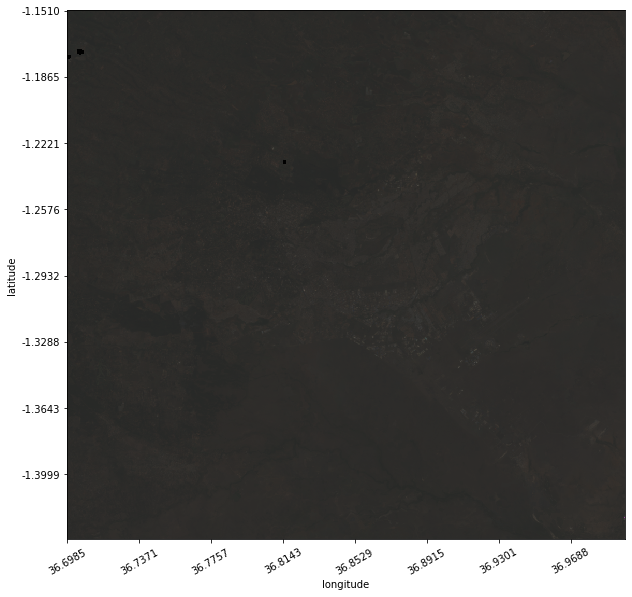

In [21]:
import matplotlib.pyplot as plt
from utils.data_cube_utilities.dc_rgb import rgb
rgb(baseline_composite, use_data_min=True, use_data_max=True)
plt.show()

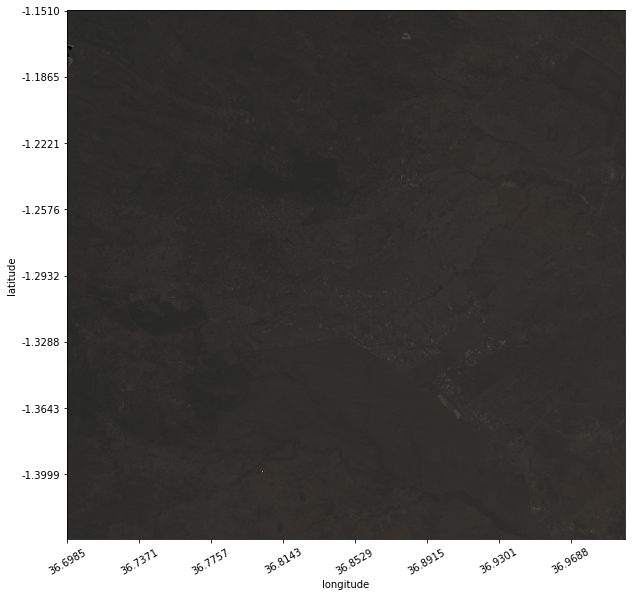

In [22]:
rgb(analysis_composite, use_data_min=True, use_data_max=True)
plt.show()

## <span id="calculate">Calculate Spectral Indices and Fractional Cover [&#9652;](#top)</span>  

In [23]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [24]:
def EVI(ds, G=2.5, C1=6, C2=7.5, L=1, normalize=True):
    evi = G * (ds.nir - ds.red) / (ds.nir + C1 * ds.red - C2 * ds.blue + L)
    # Clamp values to the range [-1,2.5].
    evi.values[evi.values < -1] = -1
    evi.values[2.5 < evi.values] = 2.5
    if normalize:
        # Scale values in the  range [0,2.5] to the range [0,1].
        pos_vals_mask = 0 < evi.values
        evi.values[pos_vals_mask] = np.interp(evi.values[pos_vals_mask], (0, 2.5), (0,1))
    return evi

In [25]:
ndvi = NDVI(baseline_composite) 
evi = EVI(baseline_composite)

In [26]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
frac_classes = frac_coverage_classify(baseline_composite, clean_mask = np.ones(baseline_composite.pixel_qa.shape).astype(np.bool)) 

<p style="color:red";><b>CHANGE INPUTS BELOW

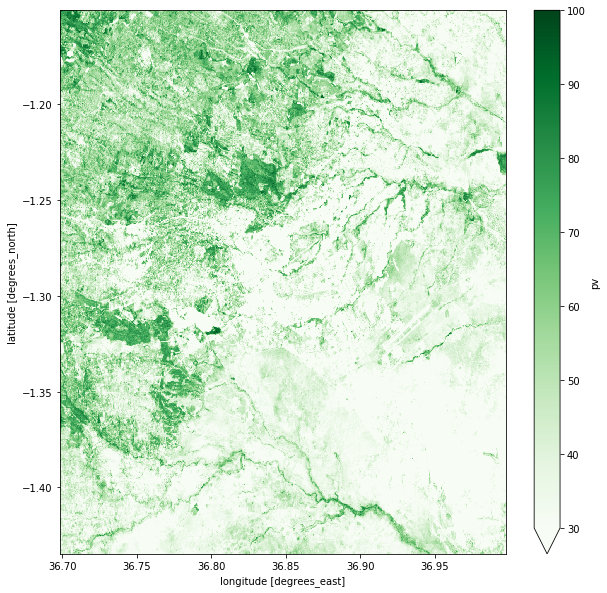

In [27]:
# Select a spectral index to plot by removing one of the comment tags (#) below.
# Only 1 of the plotting statements should be uncommented.
# Adjust the scale of the output using vmin and vmax.

# (ndvi).plot(figsize=(10,10),cmap = "Greens", vmin=0.3, vmax=1.0)
# (evi).plot(figsize=(10,10),cmap = "Greens", vmin=0.3, vmax=1.0)
(frac_classes.pv).plot(figsize=(10,10),cmap = "Greens", vmin=30.0, vmax=100.0)

plt.show()

## <span id="threshold">Show Threshold Image [&#9652;](#top)</span>  

<p style="color:red";><b>CHANGE INPUTS BELOW

In [28]:
# Select a baseline threshold range for a given parameter ... which is basically a "mask"
# The analysis will only consider pixels in this range for change detection
# No data or cloud pixels will also be masked in this process

# If you want to see all change, you should select the full range of values for each parameter
# NDVI full range = -1.0 to 1.0
# EVI full range = -1.0 to 1.0
# Fractional Cover full range = 0.0 to 100.0

# If you want to mask out everything but dense vegetation, typical of forested land, use the values below
# NDVI: 0.7 to 1.0
# EVI: 0.7 to 1.0
# Fractional Cover PV: 70.0 to 100.0

baseline_threshold_range = _min, _max = (70.0, 100.0) 

<p style="color:red";><b>CHANGE INPUTS BELOW

In [29]:
# Select the parameter to be used for thresholding ... NDVI, EVI or FC
# Remove the comment statement to use the desired parameter

# baseline_filter_mask = np.logical_and(NDVI(baseline_composite) > _min, NDVI(baseline_composite) < _max)    
# baseline_filter_mask = np.logical_and(EVI(baseline_composite) > _min, EVI(baseline_composite) < _max)    
baseline_filter_mask = np.logical_and(frac_classes.pv > _min, frac_classes.pv < _max)    

In [30]:
def aspect_ratio_helper(ds, fixed_width = 12):
        y,x = ds.values.shape
        width = fixed_width
        height = y * (fixed_width / x)
        return (width, height)

In [31]:
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn, Greens
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

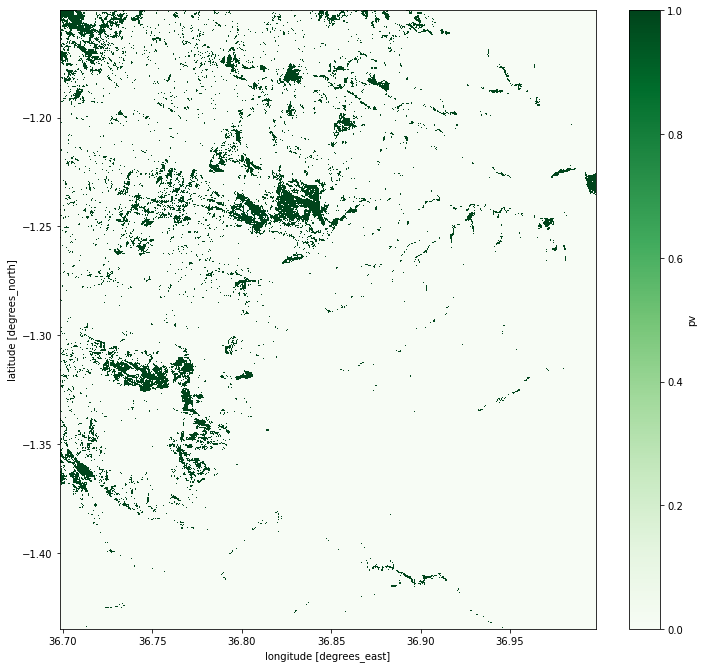

In [32]:
# This is the baseline threshold plot that shows GREEN pixels in the threshold range
# Pixels with values outside the threshold range are white 

plt.figure(figsize = aspect_ratio_helper(baseline_filter_mask)) 
baseline_filter_mask.plot(cmap = "Greens")
plt.show()

**Filter the baseline composite with the threshold mask.**

In [33]:
baseline_composite = baseline_composite.where(baseline_filter_mask)

## <span id="anomalies">Show Anomalies [&#9652;](#top)</span>  

### Show Spectral Anomaly Product

<p style="color:red";><b>CHANGE INPUTS BELOW

In [34]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 

# Select the parameter to be used for the analysis
# You will select two lines for each parameter (baseline and analysis)

# Select these two lines for NDVI
# parameter_baseline_composite = NDVI(baseline_composite)
# parameter_analysis_composite = NDVI(analysis_composite)

# Select these two lines for EVI
# parameter_baseline_composite = EVI(baseline_composite)
# parameter_analysis_composite = EVI(analysis_composite)

# Select these two lines for Fractional Cover (FC)
parameter_baseline_composite = frac_coverage_classify(baseline_composite, clean_mask = np.ones(baseline_composite.pixel_qa.shape).astype(np.bool)).pv
parameter_analysis_composite = frac_coverage_classify(analysis_composite, clean_mask = np.ones(analysis_composite.pixel_qa.shape).astype(np.bool)).pv 

In [35]:
parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite

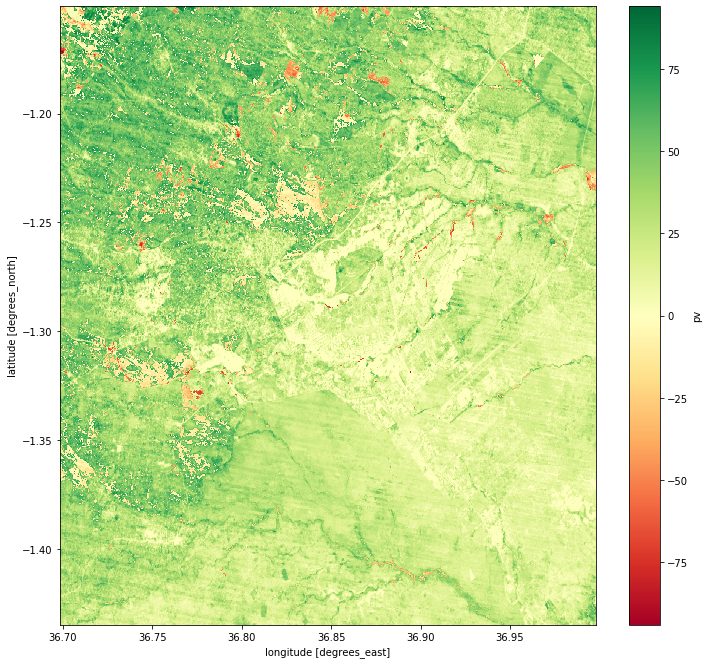

In [36]:
# Plot the parameter change from the baseline to the analysis period
# Significant loss in vegetation will be shown in RED
# Gains in vegetation will be shown in GREEN

plt.figure(figsize = aspect_ratio_helper(parameter_anomaly)) 
parameter_anomaly.plot(cmap = RdYlGn)
plt.show()

### Show Threshold Spectral Anomaly Product

<p style="color:red";><b>CHANGE INPUTS BELOW

In [37]:
# Select an Anomaly Threshold Range to filter the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)

# Losses are typically in these ranges for deforestation
# NDVI: -0.2 to -0.7
# EVI: -0.5 to -1.75
# Fractional Cover PV: -20 to -70

minimum_change = -70
maximum_change = -20


In [38]:
# Create a threshold plot using the MIN and MAX range defined above

from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

In [39]:
no_data_mask = np.logical_or(np.isnan(baseline_composite.red.values), np.isnan(analysis_composite.red.values)) 

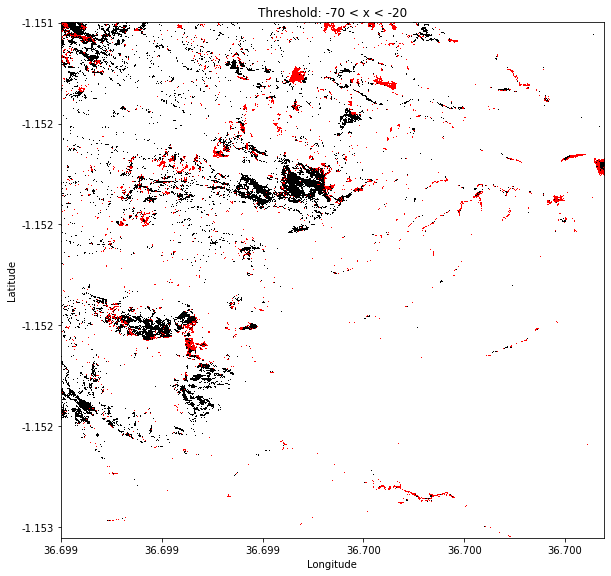

In [40]:
# Plot the parameter change using thresholds and 3 colors 
# RED = data in the threshold range (significant land change)
# BLACK = data outside the threshold range (no significant change)
# WHITE = data outside the baseline mask (not dense vegetation) or clouds (no data)

threshold_plot(parameter_anomaly, minimum_change, maximum_change, mask = no_data_mask, width  = 10)

In [41]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [42]:
# This output is a count of the pixels that fall within each threshold range

threshold_count(parameter_anomaly,minimum_change,maximum_change)

{'total': 1101716,
 'total_non_cloudy': 1101716,
 'inside': 16824,
 'outside': 1084892}

In [43]:
# This output is a percentage of the pixels that fall within each threshold range

threshold_percentage(parameter_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 1.5270723126468164,
 'percent_outside_threshold': 98.47292768735318,
 'percent_clouds': 0.0}

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>  

<p style="color:red";><b>CHANGE INPUTS BELOW

In [44]:
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr
import os

# Remove the comment tag # to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 
# There are 3 possible outputs ... baseline mosaic, analysis mosaic, or anomaly product

output_dir = "output/geotiffs"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# write_geotiff_from_xr(output_dir + "/sample_baseline_01.tif", bands = ['red','green','blue','nir','swir1','swir2'], baseline_composite)
# write_geotiff_from_xr(output_dir + "/sample_analysis_01.tif", bands = ['red','green','blue','nir','swir1','swir2'], analysis_composite)
write_geotiff_from_xr(output_dir + "/sample_anomaly_01.tif", parameter_anomaly.to_dataset(name='pv'), bands=['pv'])

In [45]:
!ls -lah output/geotiffs/*.tif

-rw-r--r-- 1 jovyan users  14M Apr 23 04:30 ../output/geotiffs/DEMO_median_composite.tif
-rw-r--r-- 1 jovyan users 4.3M Apr 23 05:23 ../output/geotiffs/sample_anomaly_01.tif
